## Загрузим необходимые модули/библиотеки

In [1]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

In [2]:
import torch
import torchvision
import PIL

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
PIL.__version__

'5.3.0'

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Подключимся к гугл диску, на котором лежит архив с картинками

In [6]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
!ls /content/gdrive/

MyDrive  Shareddrives


In [8]:
!ls -l /content/gdrive/MyDrive

total 618733
-r-------- 2 root root  87277669 Nov 29  2020 '2020-11-29 20-57-08 (online-video-cutter.com).mp4'
drwx------ 2 root root      4096 Sep  4  2020  Classroom
drwx------ 2 root root      4096 Oct  3  2020 'Colab Notebooks'
-r-------- 2 root root     16649 Oct  6  2020 'CV англ.docx'
drwx------ 2 root root      4096 Oct 12 16:24  DLS_kaggle
-rw------- 1 root root 546258348 Nov 13 11:02  journey-springfield.zip
drwx------ 2 root root      4096 Nov 15 07:05  Sims
-r-------- 2 root root     12584 Oct 13  2020 'Сопроводительное письмо.docx'


In [9]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Проверим наличие памяти на видеокарте

In [10]:
!nvidia-smi
torch.cuda.is_available()

Fri Nov 19 11:00:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

In [12]:
DEVICE

device(type='cuda')

In [13]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        data_transforms = transforms.Compose([
            transforms.ToTensor(),   
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5)
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = data_transforms(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
!ls journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [18]:
!ls journey-springfield/train/simpsons_dataset

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [19]:
TRAIN_DIR = Path('/content/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/content/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [22]:
len(train_val_files)

20933

In [23]:
len(test_files)

991

In [33]:
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

In [34]:
train_val_dataset

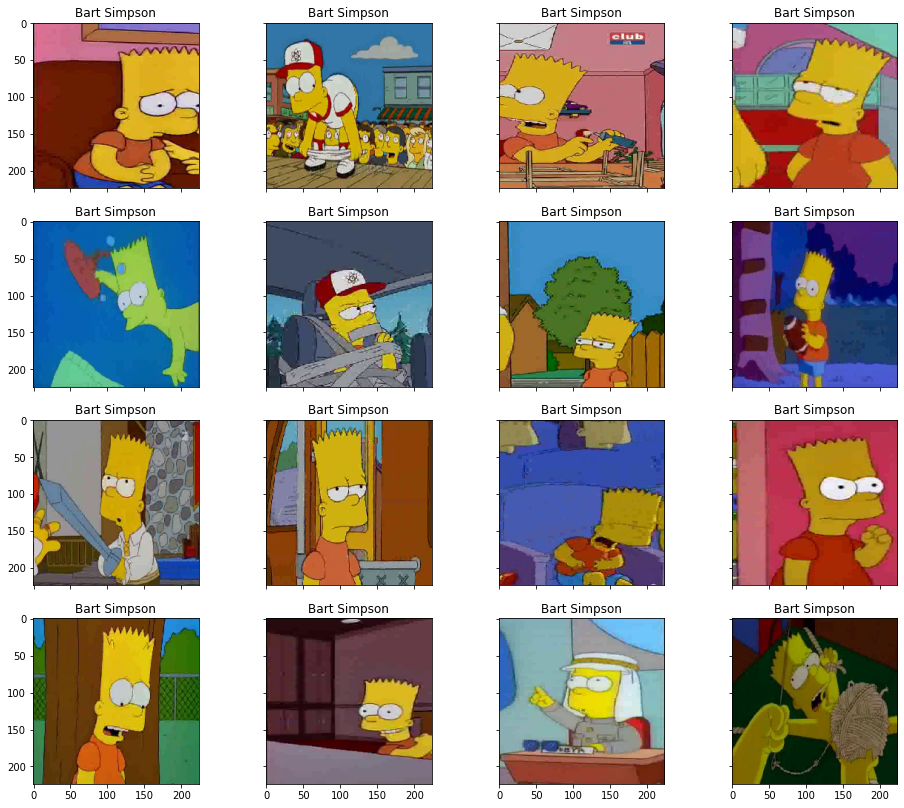

In [35]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(16, 14), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(2000,3000))
    im_val, label = train_val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Выделим из тренировочного датасета валидационный. К тому же перемешаем данные, так как загружали в отсортированном порядке.

In [29]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels,shuffle = True)

In [32]:
# len(train_files)

In [36]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Подсказали в комментариях, проверить тренировочную часть на сбалансированность. Действительно, можно заметить ее отсутствие) причем довольно сильное. Количество картинок в некоторых классах отличается на несколько порядков. С этим нужно будет что-то сделать.

In [50]:
dct_simpsons_wht = {}
dct_simpsons = create_dct_from_labels(train_labels)
for key in dct_simpsons:
    dct_simpsons_wht.update({key:1. / dct_simpsons[key]})
dct_simpsons_wht

{'abraham_grampa_simpson': 0.00145985401459854,
 'agnes_skinner': 0.03125,
 'apu_nahasapeemapetilon': 0.0021413276231263384,
 'barney_gumble': 0.0125,
 'bart_simpson': 0.0009940357852882703,
 'carl_carlson': 0.013513513513513514,
 'charles_montgomery_burns': 0.0011173184357541898,
 'chief_wiggum': 0.0013531799729364006,
 'cletus_spuckler': 0.02857142857142857,
 'comic_book_guy': 0.002840909090909091,
 'disco_stu': 0.16666666666666666,
 'edna_krabappel': 0.0029154518950437317,
 'fat_tony': 0.05,
 'gil': 0.05,
 'groundskeeper_willie': 0.01098901098901099,
 'homer_simpson': 0.0005938242280285036,
 'kent_brockman': 0.002680965147453083,
 'krusty_the_clown': 0.0011061946902654867,
 'lenny_leonard': 0.004291845493562232,
 'lionel_hutz': 0.5,
 'lisa_simpson': 0.0009852216748768472,
 'maggie_simpson': 0.010416666666666666,
 'marge_simpson': 0.0010330578512396695,
 'martin_prince': 0.018867924528301886,
 'mayor_quimby': 0.005405405405405406,
 'milhouse_van_houten': 0.0012360939431396785,
 'miss

Сеть, предложенная в качестве baseline-а. Качество без всяких изменений получается, ожидаемо, посредственное. Можно добавить/изменить слои, добавить BN, Dropout, провести еще какие-нибудь махинации. Однако, хотелось посмотреть на существующие рабочие архитектуры, поэтому на оптимизацию этой сети много времени не тратил.

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

Что изменил/добавил в train-е. Во-первых, добавим сэмплирование, реализованное в torch-е - WeightedRandomSampler, для этого нужно посчитать веса (что отчасти сделали выше) и передать доп. параметром в даталоадер. Также добавил понижение lr с помощью шедулера, каждые 10 эпох снижать в 2 раза.

In [39]:
def train(train_files, val_files, model, epochs, batch_size):

    target = train_files.labels
    class_sample_count = np.unique(target, return_counts=True)[1]
    dct_simpsons_wht = {}
    dct_simpsons = create_dct_from_labels(train_labels)

    for key in dct_simpsons:
        dct_simpsons_wht.update({key:1. / dct_simpsons[key]})

    dct_simpsons_wht_train = {}
    dct_simpsons_train = create_dct_from_labels(train_labels)

    for key in dct_simpsons_train:
        dct_simpsons_wht_train.update({key:1. / dct_simpsons_train[key]})

    class_count = [i for i in dct_simpsons_wht_train.values()]
    class_weights = torch.tensor(class_count, dtype=torch.float)

    sample_weights = [0] * len(train_files)

    for indx, (data, label) in enumerate(train_files):
        class_weight = class_weights[label]
        sample_weights[indx] = class_weight

    # print(class_weights, len(dct_simpsons_wht_train))
    sampler_train_wht = torch.utils.data.WeightedRandomSampler(sample_weights,
                                                               len(sample_weights),
                                                               replacement=True)

    # train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True, num_workers=2)
    train_loader = DataLoader(train_files, batch_size=batch_size, sampler=sampler_train_wht, num_workers=2)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())

        opt = torch.optim.Adam(list(model.features.parameters())[-layers_to_unfreeze:] + 
                              list(model.classifier.parameters()), lr=1e-4)

        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # if (epoch % 10 == 0) and (epoch != 0):
            #     !nvidia-smi
            if (epoch % 3 == 0) and (epoch != 0):
                torch.save(model.state_dict(), "model_weights_{}.pth".format(epoch))
                # files.download("model_weights_{}.pth".format(epoch))
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            # print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [40]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    # шаг шедулера ставится после оптимизатора
    scheduler.step()
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [41]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [42]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [43]:
train_labels = [path.parent.name for path in train_files]

In [ ]:
# dct_simpsons_wht_train = {}
# dct_simpsons_train = create_dct_from_labels(train_labels)
# for key in dct_simpsons_train:
#     dct_simpsons_wht_train.update({key:1. / dct_simpsons_train[key]})

In [ ]:
# dct_simpsons_wht_train

In [44]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [45]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

2 способ: Мы можем вручную добавить какое-то количесвто файлов в каждый класс

Одним из способов борьбы с несбалансированными классами было предложено "вручную" добавить картинок, просто скопировав существующие много раз с аугментацией. После некоторых экспериментов решил отказаться от данной идеи, однако код оставлю в закомментированном (чтобы был). Отказался, потому что, как мне показалось, моей аугментации недостаточно и глубокие модели просто запоминают картинку, что пагубно сказывается на их эффективности. К тому же при сравнении программного сэмплирования и ручного добавления, качество программного варианта также лучше. В общем, остановился на сэмплировании. Почитав комментарии, нашел отзывы, что у кого-то сэмплирование отрабатывает наоборот хуже. Так что надо пробовать, зависит от многих факторов.

In [ ]:
# def create_dct_path_labels(train_files, train_labels):
#     dct_simpsons = {}
#     for label_i in np.unique(train_labels).tolist():
#         dct_simpsons[label_i] = []

#     for path_i, label_i in zip(train_files, train_labels):
#         dct_simpsons[label_i].append(path_i)

#     return dct_simpsons

# def print_dct(dct_simpsons):
#     for key in dct_simpsons:
#         print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# train_labels = [path.parent.name for path in train_files] # классы train
# val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
# def create_dct_path_labels(train_files, train_labels):
#     dct_simpsons = {}
#     for label_i in np.unique(train_labels).tolist():
#         dct_simpsons[label_i] = []

#     for path_i, label_i in zip(train_files, train_labels):
#         dct_simpsons[label_i].append(path_i)

#     return dct_simpsons

# def print_dct(dct_simpsons):
#     for key in dct_simpsons:
#         print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
# dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Посмотрим, что у нас получилось.
# print_dct(dct_path_train)

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
# for person in dct_path_train:
#     if len(dct_path_train[person]) < 100:
#         dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
#         dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [46]:
# Проверим что получилось 
# for person in dct_path_train:
#     print(f"{person}\t{len(dct_path_train[person])}")

In [ ]:
# new_train_files = []

# for person in dct_path_train:
#     new_train_files.extend(dct_path_train[person])

# new_train_label = [path.parent.name for path in new_train_files] # классы train

# # выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
# # print_dct(create_dct_from_labels(new_train_label))

In [ ]:
# val_dataset = SimpsonsDataset(val_files, mode='val')
# new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

#################################

Начнем обучение. Решил взять далеко не самую "свежую", глубокую модель.

In [47]:
import torchvision.models as models

In [48]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
vgg19_bn = models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
layers_to_unfreeze = 24

In [ ]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in vgg19_bn.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [ ]:
num_features = 25088

In [ ]:
vgg19_bn.classifier = nn.Linear(num_features, n_classes)

In [ ]:
vgg19_bn = vgg19_bn.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(vgg19_bn)

we will classify :42
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [ ]:
# посмотрим какие параметры нейросети мы учим
params_to_update = vgg19_bn.parameters()
print("Params to learn:")

params_to_update = []
for name,param in vgg19_bn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.33.weight
	 features.33.bias
	 features.34.weight
	 features.34.bias
	 features.36.weight
	 features.36.bias
	 features.37.weight
	 features.37.bias
	 features.40.weight
	 features.40.bias
	 features.41.weight
	 features.41.bias
	 features.43.weight
	 features.43.bias
	 features.44.weight
	 features.44.bias
	 features.46.weight
	 features.46.bias
	 features.47.weight
	 features.47.bias
	 features.49.weight
	 features.49.bias
	 features.50.weight
	 features.50.bias
	 classifier.weight
	 classifier.bias


In [ ]:
history = train(train_dataset, val_dataset, model=vgg19_bn, epochs=30, batch_size=256)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [52]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
# С графиками получился косяк, так как обучал на кагле, и там не сохранил
# Сильно сыграло количество переобучаемых параметров, когда ставил 5-10 было посредственно,
# как только больше 20ти, качество на первой эпохе уже под 90
# Единственное можно было бы попробовать переобучить на меньшем кол-ве эпох, там было видно
# что на последних уже толку немного, но не стал время на кагле тратить.
# Обучалась 1ч 45мин

In [ ]:
# vgg19_bn.load_state_dict(torch.load("model_weights_12.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# torch.save(vgg19_bn.state_dict(), "model_vgg19_weights_21_64.pth")

### Вывод

Хочется подвести небольшой вывод. Во-первых, после экспериментов с разными архитектурами все равно остановился на vgg. Более новые архитектуры показывали иногда результат даже хуже, обучаясь дольше. Возможно, конечно, я не до конца в них разобрался. Во-вторых, количество слоев, которые мы размораживаем и которые обучаем, стало камнем преткновения. Долго с этим возился, не понимая, что именно мы делаем. Но в конечном счете, вроде +- понял. Вот кстати в новых архитектурах не так очевидно с кол-вом слоев для разморозки, если vgg "прямая" втом плане, что безо всяких inception-в, "проброски" выходов через несколько слоев. Достаточно глубокая, достаточно понятная, было приятно в ней поразбираться.

Предсказание для сэмпла


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet50, ex_img.unsqueeze(0))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## Submit on Kaagle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg19_bn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
probs

array([[7.61254400e-04, 1.05123900e-05, 1.00837613e-03, ...,
        7.72848667e-04, 3.97609512e-07, 8.09358971e-06],
       [1.90650564e-04, 2.12503091e-05, 3.34294047e-04, ...,
        1.07148371e-05, 1.19591704e-07, 5.36566526e-02],
       [2.30759455e-04, 5.83897418e-06, 1.56064052e-02, ...,
        7.27198596e-07, 2.24469077e-05, 1.07102038e-03],
       ...,
       [1.01173865e-02, 3.05511581e-04, 2.00993335e-03, ...,
        4.30651446e-04, 7.55755491e-06, 5.90751180e-03],
       [8.25631490e-04, 5.69973490e-04, 3.60848121e-02, ...,
        2.27572327e-03, 9.15323835e-06, 6.58028002e-04],
       [1.79201990e-01, 3.33591364e-04, 4.33898671e-03, ...,
        5.63643734e-05, 7.29105238e-07, 1.03117041e-02]], dtype=float32)

In [ ]:
!ls

gdrive			       model_weights_12.pth  model_weights_6.pth
journey-springfield	       model_weights_15.pth  model_weights_9.pth
label_encoder.pkl	       model_weights_18.pth  sample_data
model_vgg19_weights_21_64.pth  model_weights_3.pth


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/simple_cnn_baseline_my.csv', index=False)

In [ ]:
files.download("simple_cnn_baseline_my.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Таким образом, обученной vgg с переобчением параметров, 30 эпох, сэмплированием, шедулером, хватило, чтобы получить достаточный для максимального была результат.

Результат - 0.99043

На кагле - Фетисов_Данила_107638643